In [1]:
cd ..

/Users/TimSalzmann/Documents/Study/PhD/Code/Motion/experiments-motion


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import os
sys.path.append('./Motion')

In [4]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import yaml
from tqdm import tqdm
from IPython.display import display, HTML

In [5]:
from motion import Motion
from motion import Quaternion
from h36m.skeleton import H36MSkeleton
from h36m.dataset.h36m_torch_dataset import H36MTorchDataset
from h36m.dataset.h36m_dataset import H36MDataset
from h36m.dataset.h36m_test_dataset import H36MTestDataset
from misc.helper import add_static_nodes

In [6]:
from metrics import MeanAngleL2Error, MeanPerJointPositionError, NegativeLogLikelihood

# Load H3.6M Skeleton

In [7]:
# Load skeleton configuration
with open('./config/h36m_skeleton.yaml', 'r') as stream:
    skeleton = H36MSkeleton(**yaml.safe_load(stream))

## Define Eval Metrics

In [8]:
mae_l2_metric = MeanAngleL2Error(ignore_root=True) # We ignore the root rotation in the world for the origin joint
mpjpe_metric = MeanPerJointPositionError()
nll_metric = NegativeLogLikelihood()

In [9]:
t = [0.08, 0.16, 0.32, 0.4, 0.56, 0.72, 0.88, 1.]

## Load Evaluation Data

In [10]:
DATA_PATH = './data/processed/h3.6m.npz'

In [11]:
h36m_dataset = H36MDataset(DATA_PATH, dataset_fps=50, dataset_downsample_factor=2)

In [12]:
dataset_eval = H36MTorchDataset(h36m_dataset,
                                subjects=['S5'],
                                history_length=50,
                                prediction_horizon=25)

# Evaluation of Deterministic Model on H3.6M dataset

## Load the Model

In [13]:
MODEL_PATH = './output/h36m/deterministic/'
CHECKPOINT = 'model'
CHECKPOINT_PATH = os.path.join(MODEL_PATH, CHECKPOINT + '.pth.tar')

In [14]:
# Load model config
with open(os.path.join(MODEL_PATH, 'config.yaml'), 'r') as file:
    model_config = yaml.safe_load(file)

In [15]:
model = Motion(skeleton, T=skeleton.nodes_type_id_dynamic, **model_config)
model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=torch.device('cpu')))
model.eval()
print('Model Loaded')

Model Loaded


In [16]:
def preprocess(x):
    return Quaternion.qfix_positive_(x)

In [65]:
g_s = []
for name, param in model.named_parameters():
    if name.endswith('.G'):
        print(name)
        g_s.append(torch.nn.functional.normalize(param, p=1., dim=1).abs().detach())

core.encoder.rnn.layers.0.G
core.encoder.fc.G
core.encoder.initial_hidden1.G
core.enc_to_z.G
core.decoder.initial_hidden_h.G
core.decoder.rnn.layers.0.G
core.decoder.fc_q.G
core.decoder.fc_cov_lat.G


In [61]:
G = dict(model.core.encoder.rnn.named_parameters())['layers.0.G']

In [ ]:
G

In [62]:
gx = torch.nn.functional.normalize(G, p=1., dim=1)

In [63]:
gx[0].abs()

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], grad_fn=<AbsBackward>)

In [54]:
g_s[0][0]

tensor([0.5453, 0.0511, 0.1909, 0.0041, 0.0146, 0.0142, 0.0064, 0.0016, 0.1279,
        0.0020, 0.0039, 0.0012, 0.0023, 0.0101, 0.0059, 0.0023, 0.0011, 0.0079,
        0.0038, 0.0033])

In [57]:
g_s[2][0]

tensor([0.5453, 0.0511, 0.1909, 0.0041, 0.0146, 0.0142, 0.0064, 0.0016, 0.1279,
        0.0020, 0.0039, 0.0012, 0.0023, 0.0101, 0.0059, 0.0023, 0.0011, 0.0079,
        0.0038, 0.0033])

In [72]:
gx = torch.stack(g_s, axis=0)[3:].mean(axis=0)

In [73]:
gx[:, 0]

tensor([0.3133, 0.0848, 0.0362, 0.0200, 0.0211, 0.0305, 0.0111, 0.0088, 0.0101,
        0.0479, 0.0130, 0.0098, 0.0080, 0.0060, 0.0044, 0.0053, 0.0061, 0.0092,
        0.0046, 0.0062])

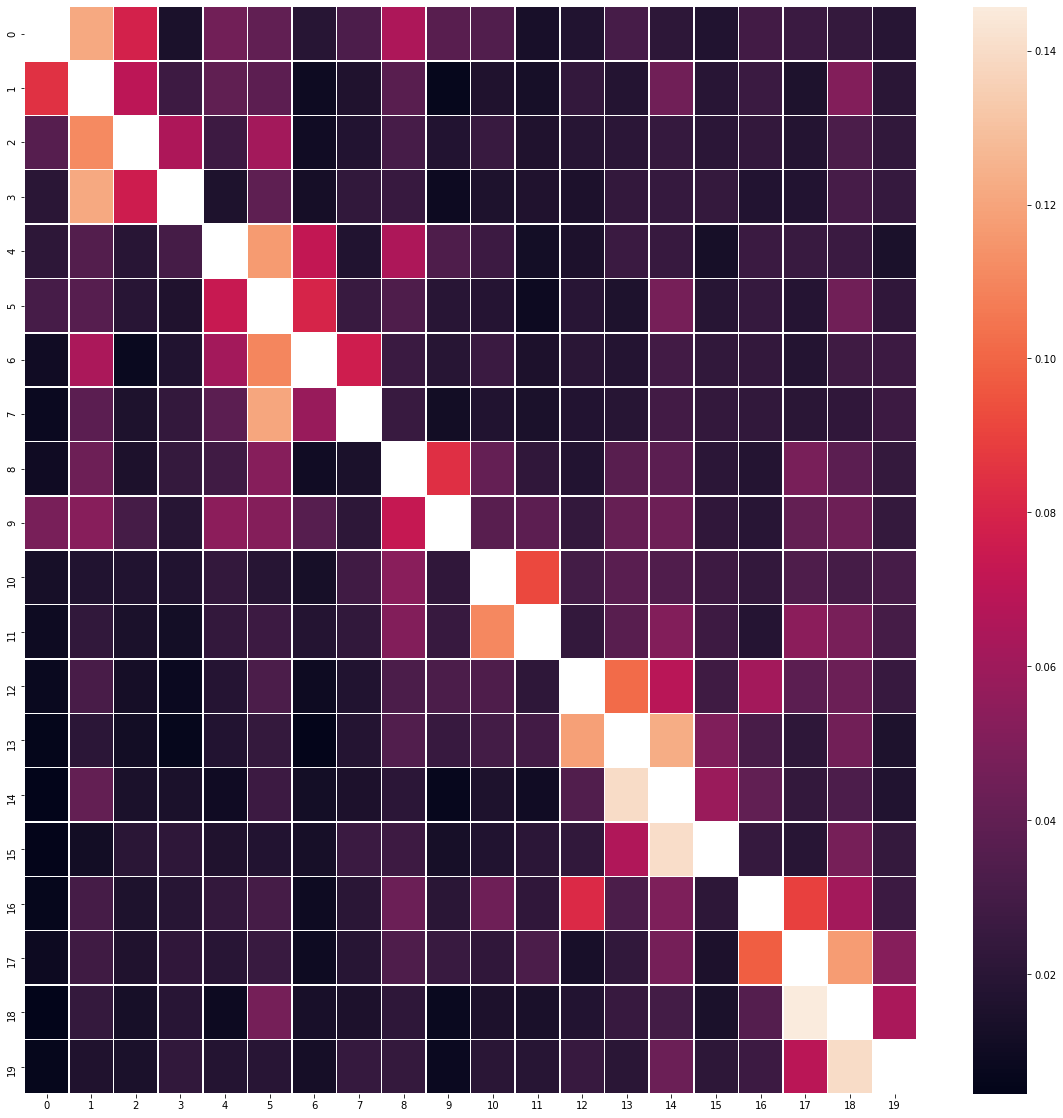

In [74]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,20)
import seaborn as sns
import numpy as np

gx_n = gx.detach().abs().numpy()
np.fill_diagonal(gx_n, np.nan)
ax = sns.heatmap(gx_n, linewidth=0.5)

#plt.imshow(gx_n, cmap='hot', interpolation='nearest')
plt.show()

# Evaluate on 8 Series per Action on Subject 5

In [22]:
ACTIONS = ['walking', 'eating', 'smoking', 'discussion', 'directions', 'greeting', 'phoning', 'posing',
           'purchases', 'sitting', 'sittingdown', 'takingphoto', 'waiting', 'walkingdog', 'walkingtogether',]

In [27]:
result = pd.DataFrame(columns=pd.MultiIndex.from_product([['Mean Angle Error (L2)', 'Mean per Joint Position Error'], ['average'] + ACTIONS]))
with torch.no_grad():
    for action in tqdm(ACTIONS):
        mae_l2_metric.reset()
        mpjpe_metric.reset()
        dataset_test_action = H36MTestDataset(h36m_dataset,
                                              action=action,
                                              subjects=['S5'],
                                              num_samples=8,
                                              history_length=50,
                                              prediction_horizon=25)
        
        for x, y in DataLoader(dataset_test_action, batch_size=256):
            # Remove static nodes
            x_dynamic = x[:, :, skeleton.dynamic_nodes]
            
            p_q, _, _, _ = model(preprocess(x_dynamic), ph=25)
            
            # The mode of the Distribution are the rotations
            q_mode = p_q.weighted_mean

            # Add static rotations q = [1., 0., 0., 0.]
            q_mode_all = add_static_nodes(q_mode, skeleton.static_nodes, skeleton.dynamic_nodes)

            mae_l2_metric.update((q_mode_all, y))

            pos_mode_all = skeleton(q_mode_all.view(-1, 32, 4)).view(-1, 25, 32, 3)
            pos_y = skeleton(y.view(-1, 32, 4)).view(-1, 25, 32, 3)
            mpjpe_metric.update((pos_mode_all, pos_y))
            
        mae_l2 = mae_l2_metric.compute().numpy()
        mpjpe = mpjpe_metric.compute().numpy()
        result['Mean Angle Error (L2)', action] = pd.Series(data=mae_l2, index=0.04*np.arange(1, mae_l2.shape[0] + 1))
        result['Mean per Joint Position Error', action] = pd.Series(data=mpjpe, index=0.04*np.arange(1, mpjpe.shape[0] + 1))
result['Mean Angle Error (L2)', 'average'] = result['Mean Angle Error (L2)'].mean(axis=1)
result['Mean per Joint Position Error', 'average'] = result['Mean per Joint Position Error'].mean(axis=1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.14it/s]


### Mean Angle Error (L2)

In [28]:
display(HTML(result['Mean Angle Error (L2)'].loc[t].to_html(float_format=lambda x: '%.2f' % x)))

,average,walking,eating,smoking,discussion,directions,greeting,phoning,posing,purchases,sitting,sittingdown,takingphoto,waiting,walkingdog,walkingtogether
0.08,0.26,0.18,0.16,0.21,0.21,0.29,0.35,0.41,0.19,0.41,0.26,0.29,0.13,0.20,0.41,0.13
0.16,0.48,0.31,0.29,0.42,0.56,0.38,0.58,0.62,0.48,0.64,0.44,0.60,0.34,0.46,0.71,0.31
0.32,0.81,0.51,0.49,0.79,0.80,0.63,0.87,1.12,1.03,1.06,0.79,0.93,0.58,0.88,1.15,0.48
0.40,0.93,0.55,0.61,0.89,0.90,0.72,1.03,1.19,1.25,1.14,0.99,1.08,0.70,1.09,1.32,0.54
0.56,1.12,0.61,0.72,0.96,1.23,0.87,1.29,1.36,1.55,1.42,1.12,1.30,0.78,1.46,1.52,0.67
0.72,1.28,0.65,0.77,1.02,1.51,1.08,1.34,1.39,1.96,1.66,1.28,1.51,0.83,1.77,1.69,0.78
0.88,1.46,0.64,0.96,1.33,1.57,1.29,1.53,1.53,2.22,2.00,1.52,1.64,0.89,2.05,1.77,0.92
1.00,1.56,0.66,1.07,1.48,1.53,1.34,1.54,1.69,2.39,2.28,1.58,1.78,0.97,2.11,1.79,1.20


### Mean per Joint Position Error

In [29]:
display(HTML(result['Mean per Joint Position Error'].loc[t].to_html(float_format=lambda x: '%.2f' % x)))

,average,walking,eating,smoking,discussion,directions,greeting,phoning,posing,purchases,sitting,sittingdown,takingphoto,waiting,walkingdog,walkingtogether
0.08,16.46,12.95,10.10,10.02,12.32,13.38,17.44,35.14,13.03,20.83,18.03,17.00,9.25,13.63,33.60,10.24
0.16,31.62,24.23,18.91,19.66,29.30,20.93,34.10,43.52,32.44,38.84,35.99,32.95,23.34,33.59,62.80,23.75
0.32,56.15,41.63,34.03,31.91,53.99,45.15,67.45,60.31,74.82,60.49,66.50,59.02,45.52,62.80,94.38,44.29
0.40,65.74,44.45,41.03,34.77,54.91,55.18,86.30,65.10,89.61,68.60,77.80,72.55,56.34,77.26,111.37,50.90
0.56,80.86,41.76,55.65,41.12,69.33,62.79,103.66,78.45,114.34,98.49,95.18,96.67,69.28,91.94,131.85,62.44
0.72,93.06,48.79,57.22,53.55,81.12,82.60,108.68,88.08,137.68,96.74,115.22,120.78,73.60,110.24,150.31,71.27
0.88,108.08,50.04,66.99,70.44,85.41,93.65,111.24,96.83,174.01,113.76,128.46,138.16,81.52,144.63,177.60,88.42
1.00,117.96,55.48,72.71,77.92,90.51,92.70,105.42,114.78,199.77,136.03,131.18,154.62,90.15,162.90,188.47,96.76


## Evaluate on 256 Series per Action on Subject 5

In [30]:
ACTIONS = ['walking', 'eating', 'smoking', 'discussion', 'directions', 'greeting', 'phoning', 'posing',
           'purchases', 'sitting', 'sittingdown', 'takingphoto', 'waiting', 'walkingdog', 'walkingtogether',]

In [31]:
result = pd.DataFrame(columns=pd.MultiIndex.from_product([['Mean Angle Error (L2)', 'Mean per Joint Position Error'], ['average'] + ACTIONS]))
with torch.no_grad():
    for action in tqdm(ACTIONS):
        mae_l2_metric.reset()
        mpjpe_metric.reset()
        dataset_test_action = H36MTestDataset(h36m_dataset,
                                              action=action,
                                              subjects=['S5'],
                                              num_samples=256,
                                              history_length=50,
                                              prediction_horizon=25)
        
        for x, y in DataLoader(dataset_test_action, batch_size=256):
            # Remove static nodes
            x_dynamic = x[:, :, skeleton.dynamic_nodes]
            
            p_q, _, _, _ = model(preprocess(x_dynamic), ph=25)
            
            # The mode of the Distribution are the rotations
            q_mode = p_q.weighted_mean
            
            # Add static rotations q = [1., 0., 0., 0.]
            q_mode_all = add_static_nodes(q_mode, skeleton.static_nodes, skeleton.dynamic_nodes)

            mae_l2_metric.update((q_mode_all, y))

            pos_mode_all = skeleton(q_mode_all.view(-1, 32, 4)).view(-1, 25, 32, 3)
            pos_y = skeleton(y.view(-1, 32, 4)).view(-1, 25, 32, 3)
            mpjpe_metric.update((pos_mode_all, pos_y))
            
        mae_l2 = mae_l2_metric.compute().numpy()
        mpjpe = mpjpe_metric.compute().numpy()
        result['Mean Angle Error (L2)', action] = pd.Series(data=mae_l2, index=0.04*np.arange(1, mae_l2.shape[0] + 1))
        result['Mean per Joint Position Error', action] = pd.Series(data=mpjpe, index=0.04*np.arange(1, mpjpe.shape[0] + 1))
result['Mean Angle Error (L2)', 'average'] = result['Mean Angle Error (L2)'].mean(axis=1)
result['Mean per Joint Position Error', 'average'] = result['Mean per Joint Position Error'].mean(axis=1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:53<00:00,  3.54s/it]


### Mean Angle Error (L2)

In [32]:
display(HTML(result['Mean Angle Error (L2)'].loc[t].to_html(float_format=lambda x: '%.2f' % x)))

,average,walking,eating,smoking,discussion,directions,greeting,phoning,posing,purchases,sitting,sittingdown,takingphoto,waiting,walkingdog,walkingtogether
0.08,0.28,0.23,0.20,0.21,0.36,0.19,0.40,0.28,0.24,0.44,0.23,0.41,0.20,0.23,0.41,0.20
0.16,0.51,0.43,0.41,0.38,0.63,0.38,0.68,0.51,0.50,0.75,0.45,0.72,0.33,0.44,0.69,0.36
0.32,0.87,0.68,0.79,0.65,1.02,0.75,1.14,0.84,0.93,1.18,0.85,1.17,0.60,0.83,1.05,0.59
0.40,1.01,0.74,0.90,0.80,1.16,0.94,1.31,0.98,1.12,1.28,1.01,1.36,0.72,1.00,1.16,0.68
0.56,1.22,0.88,1.06,1.02,1.41,1.13,1.51,1.19,1.42,1.48,1.28,1.68,0.91,1.23,1.30,0.83
0.72,1.40,0.94,1.23,1.21,1.54,1.26,1.70,1.41,1.71,1.69,1.53,1.90,1.10,1.42,1.48,0.92
0.88,1.54,1.03,1.38,1.34,1.63,1.38,1.84,1.58,1.96,1.77,1.70,2.12,1.25,1.58,1.59,1.01
1.00,1.63,1.08,1.45,1.44,1.70,1.46,1.90,1.66,2.10,1.86,1.81,2.22,1.36,1.69,1.68,1.06


### Mean per Joint Position Error

In [33]:
display(HTML(result['Mean per Joint Position Error'].loc[t].to_html(float_format=lambda x: '%.2f' % x)))

,average,walking,eating,smoking,discussion,directions,greeting,phoning,posing,purchases,sitting,sittingdown,takingphoto,waiting,walkingdog,walkingtogether
0.08,15.08,16.39,8.82,9.41,14.19,10.31,19.58,13.93,15.23,20.06,13.64,20.20,12.08,12.84,27.26,12.24
0.16,29.90,30.97,18.02,18.83,29.62,21.70,38.13,27.36,33.71,39.47,27.78,38.35,24.21,26.28,50.33,23.78
0.32,55.61,49.53,33.87,35.55,57.94,45.26,71.20,51.00,68.07,70.55,54.86,68.93,47.64,53.97,83.65,42.08
0.40,66.24,55.76,40.94,42.51,69.15,56.22,84.14,61.58,83.98,82.61,66.70,82.52,58.64,66.23,93.55,49.05
0.56,83.67,64.13,52.97,54.38,87.53,70.06,104.77,77.45,114.19,100.66,87.61,108.13,76.63,84.29,112.63,59.69
0.72,97.95,69.19,62.40,64.88,102.22,82.70,119.31,92.51,141.89,113.88,106.49,129.48,94.59,99.34,124.21,66.20
0.88,110.11,74.04,70.73,73.45,111.50,94.18,131.84,102.83,164.01,126.96,122.98,147.72,107.80,112.95,139.34,71.40
1.00,117.89,80.18,77.21,79.46,116.63,99.72,135.63,111.57,179.26,135.65,131.70,159.89,117.06,119.67,150.15,74.56


# Evaluation of Model on H3.6M dataset

In [34]:
mode_probs = []

In [40]:
def sorted_modes(p_q):
    qs = p_q.component_distribution.mean
    probs = p_q.mixture_distribution.probs
    w = probs
    probs_sorted, si = w.sort(-1, descending=True)
    mode_probs.append(probs_sorted)
    si = si.repeat(1 ,qs.shape[1], qs.shape[2], 1)
    q_mode = qs.gather(dim=-2, index=si.unsqueeze(-1).repeat(1, 1, 1, 1, 4)).squeeze(-2)
    return q_mode

In [41]:
def mae_l2_modes(modes, y):
    e1f = Quaternion.euler_angle_(modes.contiguous(), 'zyx').flatten(start_dim=-2)
    e2f = Quaternion.euler_angle_(y.contiguous(), 'zyx').flatten(start_dim=-2)
    diff_modes = torch.remainder(e1f - e2f + np.pi, 2 * np.pi) - np.pi
    _, idx = diff_modes.norm(dim=-1).mean(1).min(-1)
    return diff_modes.norm(dim=-1).gather(dim=-1, 
                             index=idx.unsqueeze(-1).unsqueeze(-1).repeat(1, diff_modes.shape[1], 1)).mean(0).squeeze()

In [42]:
def mpjpe_modes(modes, y):
    pos_modes = skeleton(modes.view(-1, 32, 4)).view(modes.shape[:-1] + (3,))
    pos_y = skeleton(y.view(-1, 32, 4)).view(y.shape[:-1] + (3,))
    diff_modes = (pos_y - pos_modes).norm(dim=-1)
    _, idx = diff_modes.mean(dim=[1, -1]).min(-1)
    return diff_modes.mean(-1).gather(dim=-1, 
                             index=idx.unsqueeze(-1).unsqueeze(-1).repeat(1, diff_modes.shape[1], 1)).squeeze().mean(0)

## Evaluate on 8 Series per Action on Subject 5

In [38]:
ACTIONS = ['walking', 'eating', 'smoking', 'discussion', 'directions', 'greeting', 'phoning', 'posing',
           'purchases', 'sitting', 'sittingdown', 'takingphoto', 'waiting', 'walkingdog', 'walkingtogether',]

In [63]:
result = pd.DataFrame(columns=pd.MultiIndex.from_product([['Mean Angle Error (L2)', 'Mean per Joint Position Error'], ['average'] + ACTIONS]))
result_bo3 = pd.DataFrame(columns=pd.MultiIndex.from_product([['Mean Angle Error (L2)', 'Mean per Joint Position Error'], ['average'] + ACTIONS]))
result_bo5 = pd.DataFrame(columns=pd.MultiIndex.from_product([['Mean Angle Error (L2)', 'Mean per Joint Position Error'], ['average'] + ACTIONS]))
result_bo10 = pd.DataFrame(columns=pd.MultiIndex.from_product([['Mean Angle Error (L2)', 'Mean per Joint Position Error'], ['average'] + ACTIONS]))
with torch.no_grad():
    for action in tqdm(ACTIONS):
        mae_l2_metric.reset()
        mpjpe_metric.reset()
        modes = []
        dataset_test_action = H36MTestDataset(h36m_dataset,
                                              action=action,
                                              subjects=['S5'],
                                              num_samples=8,
                                              history_length=50,
                                              prediction_horizon=25)
        
        for x, y in DataLoader(dataset_test_action, batch_size=256):
            # Remove static nodes
            x_dynamic = x[:, :, skeleton.dynamic_nodes]
            
            p_q, _, _, _ = model(preprocess(x_dynamic), ph=25)
            
            # The mode of the Distribution are the rotations
            q_mode = p_q.mode
            
            # Add static rotations q = [1., 0., 0., 0.]
            q_mode_all = add_static_nodes(q_mode, skeleton.static_nodes, skeleton.dynamic_nodes)
            
            modes.append(add_static_nodes(sorted_modes(p_q).permute(0, 1, 3, 2, 4), skeleton.static_nodes, skeleton.dynamic_nodes))

            mae_l2_metric.update((q_mode_all, y))

            pos_mode_all = skeleton(q_mode_all.view(-1, 32, 4)).view(-1, 25, 32, 3)
            pos_y = skeleton(y.view(-1, 32, 4)).view(-1, 25, 32, 3)
            mpjpe_metric.update((pos_mode_all, pos_y))
            
        mae_l2 = mae_l2_metric.compute().numpy()
        mpjpe = mpjpe_metric.compute().numpy()
        mae_l2_bo3 = mae_l2_modes(torch.cat(modes, dim=0)[..., :3, 1:, :], mae_l2_metric.y[..., 1:, :].unsqueeze(2))
        mpjpe_bo3 = mpjpe_modes(torch.cat(modes, dim=0)[..., :3, :, :].contiguous(), mae_l2_metric.y.unsqueeze(2))
        mae_l2_bo5 = mae_l2_modes(torch.cat(modes, dim=0)[..., :5, 1:, :], mae_l2_metric.y[..., 1:, :].unsqueeze(2))
        mpjpe_bo5 = mpjpe_modes(torch.cat(modes, dim=0)[..., :5, :, :].contiguous(), mae_l2_metric.y.unsqueeze(2))
        mae_l2_bo10 = mae_l2_modes(torch.cat(modes, dim=0)[..., :10, 1:, :], mae_l2_metric.y[..., 1:, :].unsqueeze(2))
        mpjpe_bo10 = mpjpe_modes(torch.cat(modes, dim=0)[..., :10, :, :].contiguous(), mae_l2_metric.y.unsqueeze(2))
        result['Mean Angle Error (L2)', action] = pd.Series(data=mae_l2, index=0.04*np.arange(1, mae_l2.shape[0] + 1))
        result['Mean per Joint Position Error', action] = pd.Series(data=mpjpe, index=0.04*np.arange(1, mpjpe.shape[0] + 1))
        result_bo3['Mean Angle Error (L2)', action] = pd.Series(data=mae_l2_bo3, index=0.04*np.arange(1, mae_l2.shape[0] + 1))
        result_bo3['Mean per Joint Position Error', action] = pd.Series(data=mpjpe_bo3, index=0.04*np.arange(1, mpjpe.shape[0] + 1))
        result_bo5['Mean Angle Error (L2)', action] = pd.Series(data=mae_l2_bo5, index=0.04*np.arange(1, mae_l2.shape[0] + 1))
        result_bo5['Mean per Joint Position Error', action] = pd.Series(data=mpjpe_bo5, index=0.04*np.arange(1, mpjpe.shape[0] + 1))
        result_bo10['Mean Angle Error (L2)', action] = pd.Series(data=mae_l2_bo10, index=0.04*np.arange(1, mae_l2.shape[0] + 1))
        result_bo10['Mean per Joint Position Error', action] = pd.Series(data=mpjpe_bo10, index=0.04*np.arange(1, mpjpe.shape[0] + 1))
result['Mean Angle Error (L2)', 'average'] = result['Mean Angle Error (L2)'].mean(axis=1)
result['Mean per Joint Position Error', 'average'] = result['Mean per Joint Position Error'].mean(axis=1)
result_bo3['Mean Angle Error (L2)', 'average'] = result_bo3['Mean Angle Error (L2)'].mean(axis=1)
result_bo3['Mean per Joint Position Error', 'average'] = result_bo3['Mean per Joint Position Error'].mean(axis=1)
result_bo5['Mean Angle Error (L2)', 'average'] = result_bo5['Mean Angle Error (L2)'].mean(axis=1)
result_bo5['Mean per Joint Position Error', 'average'] = result_bo5['Mean per Joint Position Error'].mean(axis=1)
result_bo10['Mean Angle Error (L2)', 'average'] = result_bo10['Mean Angle Error (L2)'].mean(axis=1)
result_bo10['Mean per Joint Position Error', 'average'] = result_bo10['Mean per Joint Position Error'].mean(axis=1)

  7%|█████████████▍                                                                                                                                                                                            | 1/15 [00:00<00:05,  2.34it/s]

 13%|██████████████████████████▉                                                                                                                                                                               | 2/15 [00:00<00:05,  2.45it/s]

 20%|████████████████████████████████████████▍                                                                                                                                                                 | 3/15 [00:01<00:04,  2.52it/s]

 27%|█████████████████████████████████████████████████████▊                                                                                                                                                    | 4/15 [00:01<00:04,  2.45it/s]

 33%|███████████████████████████████████████████████████████████████████▎                                                                                                                                      | 5/15 [00:02<00:04,  2.38it/s]

 40%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 6/15 [00:02<00:03,  2.48it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 7/15 [00:02<00:03,  2.53it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 8/15 [00:03<00:02,  2.50it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 9/15 [00:03<00:02,  2.41it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 10/15 [00:04<00:01,  2.52it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 11/15 [00:04<00:01,  2.38it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 12/15 [00:04<00:01,  2.37it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 13/15 [00:05<00:00,  2.37it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 14/15 [00:05<00:00,  2.37it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.41it/s]

### Mean Angle Error (L2)

In [64]:
display(HTML(result['Mean Angle Error (L2)'].loc[t].to_html(float_format=lambda x: '%.2f' % x)))

,average,walking,eating,smoking,discussion,directions,greeting,phoning,posing,purchases,sitting,sittingdown,takingphoto,waiting,walkingdog,walkingtogether
0.08,0.26,0.18,0.16,0.21,0.21,0.29,0.35,0.42,0.19,0.42,0.26,0.29,0.14,0.20,0.41,0.13
0.16,0.48,0.31,0.30,0.43,0.56,0.39,0.59,0.63,0.48,0.64,0.43,0.60,0.34,0.45,0.72,0.31
0.32,0.82,0.51,0.50,0.82,0.81,0.67,0.87,1.16,1.03,1.07,0.78,0.94,0.57,0.87,1.16,0.49
0.40,0.95,0.56,0.62,0.93,0.92,0.77,1.02,1.24,1.26,1.17,0.98,1.10,0.70,1.08,1.33,0.55
0.56,1.15,0.61,0.73,1.01,1.26,0.97,1.28,1.48,1.66,1.44,1.09,1.30,0.79,1.46,1.53,0.70
0.72,1.32,0.65,0.78,1.09,1.54,1.16,1.31,1.54,2.12,1.73,1.25,1.50,0.84,1.77,1.71,0.81
0.88,1.50,0.64,0.97,1.40,1.61,1.37,1.50,1.66,2.40,2.08,1.49,1.63,0.88,2.06,1.79,0.98
1.00,1.60,0.67,1.08,1.56,1.58,1.42,1.53,1.81,2.58,2.33,1.55,1.76,0.96,2.12,1.83,1.27


### Mean per Joint Position Error

In [65]:
display(HTML(result['Mean per Joint Position Error'].loc[t].to_html(float_format=lambda x: '%.2f' % x)))

,average,walking,eating,smoking,discussion,directions,greeting,phoning,posing,purchases,sitting,sittingdown,takingphoto,waiting,walkingdog,walkingtogether
0.08,16.52,12.86,10.19,10.12,12.12,13.74,17.82,35.12,12.95,20.88,18.06,17.06,9.32,13.58,33.65,10.31
0.16,31.83,23.94,19.25,19.69,29.09,21.93,35.05,43.86,32.58,39.18,35.84,33.26,23.31,33.76,62.77,23.90
0.32,56.46,41.30,34.53,32.26,54.52,46.39,67.79,60.79,74.89,61.38,65.94,59.64,46.09,63.38,94.38,43.63
0.40,66.00,44.36,41.45,34.93,55.92,57.45,85.60,65.50,89.78,69.70,77.27,72.78,56.69,77.30,111.55,49.72
0.56,81.42,42.95,56.03,40.19,70.82,67.32,102.94,81.10,115.25,100.20,94.65,95.49,68.81,91.51,133.19,60.78
0.72,93.90,49.94,58.62,51.29,83.69,86.55,106.97,91.96,142.29,98.71,115.05,117.27,72.34,110.91,151.62,71.30
0.88,109.74,52.22,70.53,67.19,88.25,98.96,109.33,101.52,182.52,117.25,128.99,134.22,79.62,145.23,180.81,89.48
1.00,119.94,58.06,76.78,74.91,92.26,98.62,104.15,121.44,210.59,140.23,131.64,148.97,88.07,164.36,193.15,95.92


### Mean Angle Error (L2) BO3

In [47]:
display(HTML(result_bo3['Mean Angle Error (L2)'].loc[t].to_html(float_format=lambda x: '%.2f' % x)))

,average,walking,eating,smoking,discussion,directions,greeting,phoning,posing,purchases,sitting,sittingdown,takingphoto,waiting,walkingdog,walkingtogether
0.08,0.26,0.18,0.16,0.22,0.21,0.27,0.35,0.41,0.20,0.42,0.26,0.29,0.14,0.20,0.40,0.13
0.16,0.47,0.31,0.27,0.43,0.56,0.39,0.58,0.61,0.51,0.64,0.42,0.60,0.34,0.46,0.70,0.30
0.32,0.79,0.51,0.46,0.76,0.81,0.61,0.85,1.02,1.12,0.99,0.75,0.92,0.56,0.87,1.14,0.48
0.40,0.91,0.56,0.59,0.84,0.91,0.71,0.99,1.08,1.37,1.04,0.93,1.08,0.67,1.05,1.29,0.53
0.56,1.07,0.61,0.70,0.89,1.21,0.75,1.22,1.19,1.58,1.36,1.02,1.28,0.73,1.35,1.50,0.64
0.72,1.19,0.65,0.75,0.93,1.41,0.97,1.27,1.25,1.72,1.46,1.19,1.46,0.78,1.60,1.66,0.72
0.88,1.37,0.64,0.92,1.24,1.47,1.23,1.46,1.41,1.96,1.80,1.46,1.56,0.85,1.89,1.74,0.84
1.00,1.49,0.67,1.01,1.40,1.50,1.29,1.47,1.61,2.16,2.20,1.52,1.70,0.94,2.00,1.76,1.12


### Mean per Joint Position Error BO3

In [48]:
display(HTML(result_bo3['Mean per Joint Position Error'].loc[t].to_html(float_format=lambda x: '%.2f' % x)))

,average,walking,eating,smoking,discussion,directions,greeting,phoning,posing,purchases,sitting,sittingdown,takingphoto,waiting,walkingdog,walkingtogether
0.08,16.47,12.85,10.01,10.07,12.88,12.70,18.13,34.98,12.90,22.00,17.43,17.02,8.86,13.32,33.69,10.16
0.16,31.44,24.06,18.47,19.37,30.57,20.27,36.31,43.76,31.50,40.49,34.59,33.17,22.29,32.50,61.23,23.03
0.32,54.67,40.39,32.03,29.70,54.06,44.89,68.88,62.07,71.59,60.20,62.25,55.94,42.90,61.73,90.72,42.67
0.40,63.28,43.02,38.30,31.83,54.17,54.14,85.48,66.53,85.02,67.63,71.75,67.29,53.07,75.10,107.25,48.62
0.56,75.31,41.48,50.96,36.12,64.40,59.72,98.77,75.19,105.22,90.04,86.11,86.65,65.46,84.39,126.31,58.89
0.72,85.80,49.09,53.04,46.55,69.59,75.94,102.54,80.58,124.30,90.16,105.99,106.10,69.84,101.62,142.50,69.10
0.88,100.18,50.33,65.44,62.43,70.31,85.95,103.23,90.41,158.42,104.20,120.32,120.43,81.05,135.02,168.64,86.53
1.00,110.42,56.53,72.70,71.23,77.21,86.26,97.86,108.19,183.10,121.54,123.95,134.89,90.18,155.35,182.81,94.51


### Mean Angle Error (L2)  BO5

In [49]:
display(HTML(result_bo5['Mean Angle Error (L2)'].loc[t].to_html(float_format=lambda x: '%.2f' % x)))

,average,walking,eating,smoking,discussion,directions,greeting,phoning,posing,purchases,sitting,sittingdown,takingphoto,waiting,walkingdog,walkingtogether
0.08,0.26,0.18,0.16,0.22,0.21,0.27,0.35,0.41,0.20,0.42,0.26,0.29,0.14,0.20,0.40,0.13
0.16,0.47,0.31,0.27,0.43,0.56,0.39,0.58,0.60,0.50,0.63,0.42,0.60,0.34,0.46,0.69,0.30
0.32,0.78,0.51,0.46,0.76,0.81,0.61,0.85,0.97,1.06,0.96,0.74,0.92,0.56,0.87,1.10,0.48
0.40,0.89,0.56,0.59,0.84,0.91,0.71,0.99,1.04,1.27,1.01,0.93,1.08,0.67,1.06,1.23,0.53
0.56,1.05,0.61,0.70,0.89,1.21,0.75,1.22,1.15,1.40,1.33,1.00,1.28,0.73,1.32,1.45,0.64
0.72,1.16,0.65,0.75,0.93,1.41,0.97,1.26,1.24,1.55,1.42,1.17,1.46,0.78,1.51,1.60,0.72
0.88,1.34,0.64,0.92,1.24,1.47,1.23,1.46,1.42,1.81,1.80,1.44,1.56,0.85,1.75,1.69,0.84
1.00,1.47,0.67,1.01,1.40,1.50,1.29,1.48,1.65,2.01,2.22,1.52,1.70,0.94,1.86,1.72,1.12


### Mean per Joint Position Error  BO5

In [50]:
display(HTML(result_bo5['Mean per Joint Position Error'].loc[t].to_html(float_format=lambda x: '%.2f' % x)))

,average,walking,eating,smoking,discussion,directions,greeting,phoning,posing,purchases,sitting,sittingdown,takingphoto,waiting,walkingdog,walkingtogether
0.08,16.43,12.85,10.01,10.07,12.88,12.59,18.13,34.78,13.01,21.28,17.36,17.02,8.96,13.25,33.74,10.55
0.16,31.05,24.06,18.47,19.37,30.57,19.71,36.31,43.21,30.43,39.05,33.92,33.17,22.34,31.35,59.54,24.26
0.32,53.74,40.39,32.03,29.70,54.06,45.00,68.88,62.10,68.54,58.98,60.22,55.94,41.40,58.40,85.71,44.69
0.40,61.81,43.02,38.30,31.83,54.17,53.60,85.48,66.71,81.08,63.91,69.19,67.29,50.61,69.90,101.50,50.58
0.56,72.91,41.48,50.96,36.12,64.40,57.42,98.77,73.60,95.76,83.03,82.27,86.65,61.90,78.09,123.22,60.05
0.72,83.57,49.09,53.04,46.55,69.59,73.98,102.54,79.89,117.43,85.07,101.88,106.10,66.07,95.00,139.80,67.60
0.88,98.33,50.33,65.44,62.43,70.31,85.20,103.23,91.60,158.23,96.93,117.66,120.43,79.68,128.95,160.81,83.77
1.00,108.37,56.53,72.70,71.23,77.21,86.56,97.86,108.68,183.61,109.94,122.51,134.89,91.47,148.79,174.48,89.01


### Mean Angle Error (L2)  BO10

In [51]:
display(HTML(result_bo10['Mean Angle Error (L2)'].loc[t].to_html(float_format=lambda x: '%.2f' % x)))

,average,walking,eating,smoking,discussion,directions,greeting,phoning,posing,purchases,sitting,sittingdown,takingphoto,waiting,walkingdog,walkingtogether
0.08,0.26,0.18,0.16,0.22,0.21,0.27,0.35,0.41,0.20,0.42,0.26,0.29,0.14,0.20,0.40,0.13
0.16,0.47,0.31,0.27,0.43,0.56,0.39,0.58,0.60,0.50,0.63,0.42,0.60,0.34,0.46,0.69,0.30
0.32,0.78,0.51,0.46,0.76,0.81,0.61,0.85,0.97,1.06,0.96,0.74,0.92,0.56,0.87,1.10,0.48
0.40,0.89,0.56,0.59,0.84,0.91,0.71,0.99,1.04,1.27,1.01,0.93,1.08,0.67,1.06,1.23,0.53
0.56,1.05,0.61,0.70,0.89,1.21,0.75,1.22,1.15,1.40,1.33,1.00,1.28,0.73,1.32,1.45,0.64
0.72,1.16,0.65,0.75,0.93,1.41,0.97,1.26,1.24,1.55,1.42,1.17,1.46,0.78,1.51,1.60,0.72
0.88,1.34,0.64,0.92,1.24,1.47,1.23,1.46,1.42,1.81,1.80,1.44,1.56,0.85,1.75,1.69,0.84
1.00,1.47,0.67,1.01,1.40,1.50,1.29,1.48,1.65,2.01,2.22,1.52,1.70,0.94,1.86,1.72,1.12


### Mean per Joint Position Error  BO10

In [52]:
display(HTML(result_bo10['Mean per Joint Position Error'].loc[t].to_html(float_format=lambda x: '%.2f' % x)))

,average,walking,eating,smoking,discussion,directions,greeting,phoning,posing,purchases,sitting,sittingdown,takingphoto,waiting,walkingdog,walkingtogether
0.08,16.43,12.85,10.01,10.07,12.88,12.59,18.13,34.78,13.01,21.28,17.36,17.02,8.96,13.25,33.74,10.55
0.16,31.05,24.06,18.47,19.37,30.57,19.71,36.31,43.21,30.43,39.05,33.92,33.17,22.34,31.35,59.54,24.26
0.32,53.74,40.39,32.03,29.70,54.06,45.00,68.88,62.10,68.54,58.98,60.22,55.94,41.40,58.40,85.71,44.69
0.40,61.81,43.02,38.30,31.83,54.17,53.60,85.48,66.71,81.08,63.91,69.19,67.29,50.61,69.90,101.50,50.58
0.56,72.91,41.48,50.96,36.12,64.40,57.42,98.77,73.60,95.76,83.03,82.27,86.65,61.90,78.09,123.22,60.05
0.72,83.57,49.09,53.04,46.55,69.59,73.98,102.54,79.89,117.43,85.07,101.88,106.10,66.07,95.00,139.80,67.60
0.88,98.33,50.33,65.44,62.43,70.31,85.20,103.23,91.60,158.23,96.93,117.66,120.43,79.68,128.95,160.81,83.77
1.00,108.37,56.53,72.70,71.23,77.21,86.56,97.86,108.68,183.61,109.94,122.51,134.89,91.47,148.79,174.48,89.01


## Evaluate on 256 Series per Action on Subject 5

In [66]:
ACTIONS = ['walking', 'eating', 'smoking', 'discussion', 'directions', 'greeting', 'phoning', 'posing',
           'purchases', 'sitting', 'sittingdown', 'takingphoto', 'waiting', 'walkingdog', 'walkingtogether',]

In [67]:
result = pd.DataFrame(columns=pd.MultiIndex.from_product([['Mean Angle Error (L2)', 'Mean per Joint Position Error'], ['average'] + ACTIONS]))
result_bo3 = pd.DataFrame(columns=pd.MultiIndex.from_product([['Mean Angle Error (L2)', 'Mean per Joint Position Error'], ['average'] + ACTIONS]))
result_bo5 = pd.DataFrame(columns=pd.MultiIndex.from_product([['Mean Angle Error (L2)', 'Mean per Joint Position Error'], ['average'] + ACTIONS]))
result_bo10 = pd.DataFrame(columns=pd.MultiIndex.from_product([['Mean Angle Error (L2)', 'Mean per Joint Position Error'], ['average'] + ACTIONS]))
with torch.no_grad():
    for action in tqdm(ACTIONS):
        mae_l2_metric.reset()
        mpjpe_metric.reset()
        modes = []
        dataset_test_action = H36MTestDataset(h36m_dataset,
                                              action=action,
                                              subjects=['S5'],
                                              num_samples=256,
                                              history_length=50,
                                              prediction_horizon=25)
        
        for x, y in DataLoader(dataset_test_action, batch_size=256):
            # Remove static nodes
            x_dynamic = x[:, :, skeleton.dynamic_nodes]
            
            p_q, _, _, _ = model(preprocess(x_dynamic), ph=25)
            
            # The mode of the Distribution are the rotations
            q_mode = p_q.mode
            
            # Add static rotations q = [1., 0., 0., 0.]
            q_mode_all = add_static_nodes(q_mode, skeleton.static_nodes, skeleton.dynamic_nodes)
            
            modes.append(add_static_nodes(sorted_modes(p_q).permute(0, 1, 3, 2, 4), skeleton.static_nodes, skeleton.dynamic_nodes))

            mae_l2_metric.update((q_mode_all, y))

            pos_mode_all = skeleton(q_mode_all.view(-1, 32, 4)).view(-1, 25, 32, 3)
            pos_y = skeleton(y.view(-1, 32, 4)).view(-1, 25, 32, 3)
            mpjpe_metric.update((pos_mode_all, pos_y))
            
        mae_l2 = mae_l2_metric.compute().numpy()
        mpjpe = mpjpe_metric.compute().numpy()
        mae_l2_bo3 = mae_l2_modes(torch.cat(modes, dim=0)[..., :3, 1:, :], mae_l2_metric.y[..., 1:, :].unsqueeze(2))
        mpjpe_bo3 = mpjpe_modes(torch.cat(modes, dim=0)[..., :3, :, :].contiguous(), mae_l2_metric.y.unsqueeze(2))
        mae_l2_bo5 = mae_l2_modes(torch.cat(modes, dim=0)[..., :5, 1:, :], mae_l2_metric.y[..., 1:, :].unsqueeze(2))
        mpjpe_bo5 = mpjpe_modes(torch.cat(modes, dim=0)[..., :5, :, :].contiguous(), mae_l2_metric.y.unsqueeze(2))
        mae_l2_bo10 = mae_l2_modes(torch.cat(modes, dim=0)[..., :10, 1:, :], mae_l2_metric.y[..., 1:, :].unsqueeze(2))
        mpjpe_bo10 = mpjpe_modes(torch.cat(modes, dim=0)[..., :10, :, :].contiguous(), mae_l2_metric.y.unsqueeze(2))
        result['Mean Angle Error (L2)', action] = pd.Series(data=mae_l2, index=0.04*np.arange(1, mae_l2.shape[0] + 1))
        result['Mean per Joint Position Error', action] = pd.Series(data=mpjpe, index=0.04*np.arange(1, mpjpe.shape[0] + 1))
        result_bo3['Mean Angle Error (L2)', action] = pd.Series(data=mae_l2_bo3, index=0.04*np.arange(1, mae_l2.shape[0] + 1))
        result_bo3['Mean per Joint Position Error', action] = pd.Series(data=mpjpe_bo3, index=0.04*np.arange(1, mpjpe.shape[0] + 1))
        result_bo5['Mean Angle Error (L2)', action] = pd.Series(data=mae_l2_bo5, index=0.04*np.arange(1, mae_l2.shape[0] + 1))
        result_bo5['Mean per Joint Position Error', action] = pd.Series(data=mpjpe_bo5, index=0.04*np.arange(1, mpjpe.shape[0] + 1))
        result_bo10['Mean Angle Error (L2)', action] = pd.Series(data=mae_l2_bo10, index=0.04*np.arange(1, mae_l2.shape[0] + 1))
        result_bo10['Mean per Joint Position Error', action] = pd.Series(data=mpjpe_bo10, index=0.04*np.arange(1, mpjpe.shape[0] + 1))
result['Mean Angle Error (L2)', 'average'] = result['Mean Angle Error (L2)'].mean(axis=1)
result['Mean per Joint Position Error', 'average'] = result['Mean per Joint Position Error'].mean(axis=1)
result_bo3['Mean Angle Error (L2)', 'average'] = result_bo3['Mean Angle Error (L2)'].mean(axis=1)
result_bo3['Mean per Joint Position Error', 'average'] = result_bo3['Mean per Joint Position Error'].mean(axis=1)
result_bo5['Mean Angle Error (L2)', 'average'] = result_bo5['Mean Angle Error (L2)'].mean(axis=1)
result_bo5['Mean per Joint Position Error', 'average'] = result_bo5['Mean per Joint Position Error'].mean(axis=1)
result_bo10['Mean Angle Error (L2)', 'average'] = result_bo10['Mean Angle Error (L2)'].mean(axis=1)
result_bo10['Mean per Joint Position Error', 'average'] = result_bo10['Mean per Joint Position Error'].mean(axis=1)

  0%|                                                                                                                                                                                                                  | 0/15 [00:00<?, ?it/s]

  7%|█████████████▍                                                                                                                                                                                            | 1/15 [00:04<01:00,  4.32s/it]

 13%|██████████████████████████▉                                                                                                                                                                               | 2/15 [00:08<00:58,  4.49s/it]

 20%|████████████████████████████████████████▍                                                                                                                                                                 | 3/15 [00:13<00:54,  4.53s/it]

 27%|█████████████████████████████████████████████████████▊                                                                                                                                                    | 4/15 [00:18<00:49,  4.53s/it]

 33%|███████████████████████████████████████████████████████████████████▎                                                                                                                                      | 5/15 [00:22<00:45,  4.57s/it]

 40%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 6/15 [00:27<00:41,  4.59s/it]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 7/15 [00:31<00:36,  4.58s/it]

 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 8/15 [00:36<00:32,  4.59s/it]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 9/15 [00:41<00:27,  4.58s/it]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 10/15 [00:45<00:22,  4.58s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 11/15 [00:50<00:18,  4.58s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 12/15 [00:54<00:13,  4.56s/it]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 13/15 [00:59<00:09,  4.60s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 14/15 [01:04<00:04,  4.60s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:08<00:00,  4.57s/it]


### Mean Angle Error (L2)

In [68]:
display(HTML(result['Mean Angle Error (L2)'].loc[t].to_html(float_format=lambda x: '%.2f' % x)))

,average,walking,eating,smoking,discussion,directions,greeting,phoning,posing,purchases,sitting,sittingdown,takingphoto,waiting,walkingdog,walkingtogether
0.08,0.28,0.23,0.20,0.21,0.35,0.19,0.40,0.28,0.24,0.44,0.23,0.41,0.20,0.24,0.41,0.20
0.16,0.51,0.43,0.41,0.38,0.63,0.38,0.69,0.51,0.50,0.75,0.46,0.73,0.33,0.44,0.69,0.36
0.32,0.88,0.68,0.79,0.65,1.02,0.76,1.14,0.85,0.94,1.19,0.87,1.18,0.60,0.84,1.07,0.59
0.40,1.02,0.73,0.91,0.80,1.18,0.95,1.32,1.00,1.13,1.29,1.02,1.37,0.72,1.00,1.17,0.68
0.56,1.24,0.88,1.06,1.03,1.44,1.15,1.53,1.21,1.45,1.52,1.30,1.69,0.92,1.23,1.32,0.84
0.72,1.42,0.94,1.23,1.22,1.58,1.28,1.75,1.45,1.76,1.74,1.56,1.91,1.10,1.42,1.50,0.94
0.88,1.58,1.04,1.39,1.36,1.68,1.40,1.92,1.61,2.03,1.82,1.74,2.14,1.26,1.58,1.63,1.04
1.00,1.67,1.10,1.47,1.47,1.75,1.48,1.98,1.70,2.19,1.91,1.84,2.24,1.38,1.70,1.72,1.09


### Mean per Joint Position Error

In [69]:
display(HTML(result['Mean per Joint Position Error'].loc[t].to_html(float_format=lambda x: '%.2f' % x)))

,average,walking,eating,smoking,discussion,directions,greeting,phoning,posing,purchases,sitting,sittingdown,takingphoto,waiting,walkingdog,walkingtogether
0.08,15.13,16.38,8.91,9.42,14.22,10.39,19.73,13.96,15.32,20.15,13.71,20.22,12.09,12.92,27.38,12.22
0.16,30.06,31.01,18.27,18.79,29.77,21.80,38.78,27.41,33.90,39.79,28.00,38.51,24.22,26.44,50.48,23.82
0.32,55.95,49.62,34.19,35.57,58.41,44.92,72.61,51.05,68.33,71.38,55.37,69.43,47.63,54.02,84.48,42.22
0.40,66.64,55.98,41.30,42.44,70.00,55.74,85.92,61.53,84.44,83.29,67.38,82.96,58.54,66.25,94.64,49.18
0.56,84.28,64.53,53.46,54.25,89.08,69.65,107.10,77.48,115.15,101.93,88.37,108.56,76.49,83.81,114.29,60.08
0.72,98.85,69.95,63.10,64.88,104.00,82.44,122.30,92.94,143.87,115.86,107.56,129.64,94.58,98.17,126.52,66.92
0.88,111.44,75.57,71.87,73.53,113.69,94.09,135.54,103.43,167.81,129.62,124.42,147.64,108.47,111.67,141.64,72.64
1.00,119.60,82.29,78.78,79.48,119.34,99.93,139.63,112.56,184.16,138.71,133.35,159.87,118.37,119.01,152.30,76.23


### Mean Angle Error (L2) BO3

In [70]:
display(HTML(result_bo3['Mean Angle Error (L2)'].loc[t].to_html(float_format=lambda x: '%.2f' % x)))

,average,walking,eating,smoking,discussion,directions,greeting,phoning,posing,purchases,sitting,sittingdown,takingphoto,waiting,walkingdog,walkingtogether
0.08,0.28,0.23,0.20,0.21,0.35,0.19,0.40,0.28,0.24,0.43,0.23,0.42,0.20,0.23,0.40,0.21
0.16,0.50,0.42,0.39,0.38,0.62,0.37,0.68,0.50,0.50,0.74,0.45,0.72,0.33,0.43,0.68,0.36
0.32,0.85,0.66,0.75,0.64,0.96,0.72,1.14,0.82,0.90,1.14,0.84,1.15,0.58,0.80,1.01,0.58
0.40,0.97,0.71,0.84,0.78,1.09,0.89,1.25,0.95,1.08,1.22,0.97,1.33,0.69,0.96,1.11,0.66
0.56,1.16,0.84,0.99,0.98,1.33,1.04,1.41,1.14,1.35,1.40,1.21,1.62,0.87,1.16,1.24,0.80
0.72,1.31,0.90,1.13,1.13,1.44,1.14,1.57,1.33,1.59,1.54,1.43,1.83,1.03,1.32,1.41,0.87
0.88,1.45,0.97,1.27,1.24,1.53,1.27,1.72,1.48,1.84,1.63,1.60,2.05,1.16,1.47,1.54,0.95
1.00,1.54,1.02,1.34,1.36,1.62,1.35,1.78,1.56,1.99,1.72,1.70,2.14,1.27,1.59,1.63,1.00


### Mean per Joint Position Error BO3

In [58]:
display(HTML(result_bo3['Mean per Joint Position Error'].loc[t].to_html(float_format=lambda x: '%.2f' % x)))

,average,walking,eating,smoking,discussion,directions,greeting,phoning,posing,purchases,sitting,sittingdown,takingphoto,waiting,walkingdog,walkingtogether
0.08,15.13,16.31,8.77,9.51,14.40,10.34,19.58,13.96,15.34,20.25,13.78,20.17,12.09,12.79,27.35,12.28
0.16,29.64,30.64,17.66,18.85,29.59,21.38,37.68,27.13,33.57,39.69,27.69,37.90,23.77,25.65,50.02,23.42
0.32,53.59,48.59,32.45,34.34,55.59,42.85,68.26,49.55,66.17,68.38,53.04,66.50,45.30,51.03,80.79,41.07
0.40,63.13,54.24,38.76,40.49,65.66,52.32,79.84,59.23,80.33,79.01,63.72,79.09,55.25,62.28,89.23,47.47
0.56,78.36,61.61,49.47,50.78,82.05,63.00,97.97,72.47,106.81,94.88,82.38,102.51,70.87,77.62,106.07,56.96
0.72,90.95,65.90,58.16,60.14,93.96,74.17,111.51,86.57,131.01,106.55,98.73,121.89,86.04,90.75,116.49,62.39
0.88,102.39,70.53,66.03,68.97,102.06,84.83,122.58,96.12,152.30,118.96,113.65,138.75,97.34,103.88,132.39,67.51
1.00,110.54,76.98,72.86,75.17,108.53,90.64,127.41,104.80,167.91,127.78,122.45,150.65,106.18,111.55,143.70,71.49


### Mean Angle Error (L2)  BO5

In [59]:
display(HTML(result_bo5['Mean Angle Error (L2)'].loc[t].to_html(float_format=lambda x: '%.2f' % x)))

,average,walking,eating,smoking,discussion,directions,greeting,phoning,posing,purchases,sitting,sittingdown,takingphoto,waiting,walkingdog,walkingtogether
0.08,0.28,0.23,0.20,0.21,0.35,0.19,0.40,0.28,0.24,0.44,0.23,0.42,0.20,0.23,0.40,0.21
0.16,0.51,0.42,0.39,0.38,0.62,0.37,0.69,0.50,0.50,0.74,0.45,0.72,0.33,0.43,0.68,0.36
0.32,0.84,0.65,0.74,0.64,0.96,0.71,1.13,0.81,0.90,1.12,0.83,1.15,0.58,0.80,1.00,0.58
0.40,0.96,0.70,0.83,0.77,1.09,0.87,1.23,0.94,1.07,1.20,0.96,1.31,0.69,0.94,1.09,0.66
0.56,1.13,0.83,0.95,0.94,1.31,1.01,1.38,1.11,1.32,1.36,1.18,1.58,0.86,1.13,1.23,0.79
0.72,1.28,0.89,1.08,1.09,1.42,1.12,1.54,1.30,1.53,1.51,1.39,1.78,1.01,1.27,1.39,0.86
0.88,1.42,0.96,1.23,1.21,1.49,1.25,1.69,1.45,1.77,1.60,1.56,2.00,1.14,1.41,1.53,0.94
1.00,1.51,1.02,1.31,1.33,1.59,1.34,1.76,1.54,1.93,1.69,1.67,2.09,1.25,1.53,1.62,0.99


### Mean per Joint Position Error  BO5

In [60]:
display(HTML(result_bo5['Mean per Joint Position Error'].loc[t].to_html(float_format=lambda x: '%.2f' % x)))

,average,walking,eating,smoking,discussion,directions,greeting,phoning,posing,purchases,sitting,sittingdown,takingphoto,waiting,walkingdog,walkingtogether
0.08,15.17,16.38,8.88,9.52,14.39,10.32,19.56,14.01,15.50,20.28,13.89,20.35,12.13,12.77,27.30,12.32
0.16,29.71,30.59,17.87,18.92,29.58,21.35,37.58,27.28,34.08,39.76,27.86,38.11,23.84,25.58,49.72,23.50
0.32,53.20,48.00,32.45,34.18,55.03,42.56,67.81,49.32,66.19,67.82,52.57,65.81,44.95,50.45,79.84,41.00
0.40,62.27,53.04,38.27,40.13,64.73,51.72,78.91,58.83,79.19,77.91,62.52,77.86,54.34,61.32,88.04,47.24
0.56,76.38,59.18,48.16,49.98,80.33,61.73,95.50,71.03,103.27,91.98,79.76,99.49,68.80,76.07,103.99,56.42
0.72,88.16,63.43,56.75,58.88,91.43,72.77,109.06,83.94,125.76,101.95,95.22,116.71,82.89,88.80,113.13,61.64
0.88,99.26,69.19,64.31,67.46,99.83,83.67,119.44,92.37,146.97,113.67,109.83,132.35,93.60,101.40,128.21,66.63
1.00,107.66,77.08,71.30,73.56,107.07,89.88,124.76,100.59,163.57,121.90,118.86,144.31,102.58,109.35,139.35,70.81


### Mean Angle Error (L2)  BO10

In [61]:
display(HTML(result_bo10['Mean Angle Error (L2)'].loc[t].to_html(float_format=lambda x: '%.2f' % x)))

,average,walking,eating,smoking,discussion,directions,greeting,phoning,posing,purchases,sitting,sittingdown,takingphoto,waiting,walkingdog,walkingtogether
0.08,0.28,0.23,0.20,0.21,0.35,0.19,0.40,0.28,0.24,0.44,0.23,0.42,0.20,0.23,0.40,0.21
0.16,0.51,0.42,0.39,0.38,0.62,0.37,0.69,0.50,0.50,0.74,0.45,0.72,0.33,0.43,0.68,0.36
0.32,0.84,0.65,0.74,0.64,0.96,0.71,1.13,0.81,0.90,1.12,0.83,1.15,0.58,0.80,1.00,0.58
0.40,0.96,0.70,0.83,0.77,1.09,0.87,1.23,0.94,1.07,1.20,0.96,1.31,0.69,0.94,1.09,0.66
0.56,1.13,0.83,0.95,0.94,1.31,1.01,1.38,1.11,1.32,1.36,1.18,1.58,0.86,1.13,1.23,0.79
0.72,1.28,0.89,1.08,1.09,1.42,1.12,1.54,1.30,1.53,1.51,1.39,1.78,1.01,1.27,1.39,0.86
0.88,1.42,0.96,1.23,1.21,1.49,1.25,1.69,1.45,1.77,1.60,1.56,2.00,1.14,1.41,1.53,0.94
1.00,1.51,1.02,1.31,1.33,1.59,1.34,1.76,1.54,1.93,1.69,1.67,2.09,1.25,1.53,1.62,0.99


### Mean per Joint Position Error  BO10

In [62]:
display(HTML(result_bo10['Mean per Joint Position Error'].loc[t].to_html(float_format=lambda x: '%.2f' % x)))

,average,walking,eating,smoking,discussion,directions,greeting,phoning,posing,purchases,sitting,sittingdown,takingphoto,waiting,walkingdog,walkingtogether
0.08,15.17,16.38,8.88,9.52,14.39,10.32,19.56,14.01,15.50,20.28,13.89,20.35,12.13,12.77,27.30,12.32
0.16,29.71,30.59,17.87,18.92,29.58,21.35,37.58,27.28,34.08,39.76,27.86,38.11,23.84,25.58,49.72,23.50
0.32,53.20,48.00,32.45,34.18,55.03,42.56,67.81,49.32,66.19,67.82,52.57,65.81,44.95,50.45,79.84,41.00
0.40,62.27,53.04,38.27,40.13,64.73,51.72,78.91,58.83,79.19,77.91,62.52,77.86,54.34,61.32,88.04,47.24
0.56,76.38,59.18,48.16,49.98,80.33,61.73,95.50,71.03,103.27,91.98,79.76,99.49,68.80,76.07,103.99,56.42
0.72,88.16,63.43,56.75,58.88,91.43,72.77,109.06,83.94,125.76,101.95,95.22,116.71,82.89,88.80,113.13,61.64
0.88,99.26,69.19,64.31,67.46,99.83,83.67,119.44,92.37,146.97,113.67,109.83,132.35,93.60,101.40,128.21,66.63
1.00,107.66,77.08,71.30,73.56,107.07,89.88,124.76,100.59,163.57,121.90,118.86,144.31,102.58,109.35,139.35,70.81
